# МГТУ им. Н.Э.Баумана | ИУ5 | 6 семестр | ТМО | РК№2

ИУ5-63Б | Ювенский Лев | Вариант № 19

**Задание:** https://github.com/ugapanyuk/courses_current/wiki/TMO_RK_2

**Задание.** Для заданного набора данных (по Вашему варианту) постройте модели классификации или регрессии (в зависимости от конкретной задачи, рассматриваемой в наборе данных). Для построения моделей используйте методы 1 и 2 (по варианту для Вашей группы). Оцените качество моделей на основе подходящих метрик качества (не менее двух метрик). Какие метрики качества Вы использовали и почему? Какие выводы Вы можете сделать о качестве построенных моделей? Для построения моделей необходимо выполнить требуемую предобработку данных: заполнение пропусков, кодирование категориальных признаков, и т.д.

**Метод №1:** Дерево решений

**Метод №2:** Случайный лес

**Датасет:** https://www.kaggle.com/datasets/arindam235/startup-investments-crunchbase

## Загрузка и первичный анализ

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [178]:
df = pd.read_csv("/dataset.csv", encoding="ISO-8859-1")

In [179]:
df.head()

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,"40,00,000",operating,USA,CA,Los Angeles,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,"40,000",operating,EST,NaN,Tallinn,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,"15,00,000",operating,GBR,NaN,London,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,"60,000",operating,USA,TX,Dallas,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54294 entries, 0 to 54293
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   permalink             49438 non-null  object 
 1   name                  49437 non-null  object 
 2   homepage_url          45989 non-null  object 
 3   category_list         45477 non-null  object 
 4   market                45470 non-null  object 
 5   funding_total_usd     49438 non-null  object 
 6   status                48124 non-null  object 
 7   country_code          44165 non-null  object 
 8   state_code            30161 non-null  object 
 9   region                44165 non-null  object 
 10  city                  43322 non-null  object 
 11  funding_rounds        49438 non-null  float64
 12  founded_at            38554 non-null  object 
 13  founded_month         38482 non-null  object 
 14  founded_quarter       38482 non-null  object 
 15  founded_year       

**О датасете:**

Приведены данные об инвестициях на уровне компании.

Приведены данные о статусе компании - интересной задачей было бы выяснить, помогают ли инвестиции и другие критерии определить, является ли компания действующей / закрытой / приобретенной.

Задача классификации.

## Подготовка датасета

### Удаление колонок

- `permalink, name, homepage_url`, поскольку они носят информационных характер и не влияют на определение статуса компании
- `region`, поскольку она избыточна для определения метоположения компании
- `founded_at`, 'founded_quarter', 'founded_year'. Будем использовать значения из колонок `founded_month`
- `funding_total_usd`, поскольку она содержит данные в некорректном формате
- `category_list`, поскольку она содержит список категорий, который тяжело обработать в рамках данной задачи

In [181]:
df = df.drop(['permalink', 'name', 'homepage_url', 'category_list', 'region', 'founded_at', 'founded_quarter', 'founded_year', 'funding_total_usd'], axis=1)

### Удаление пропусков

Удалим все строки, содержащие null хотя бы в одной колонке

In [182]:
df = df.dropna()

In [183]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 23217 entries, 0 to 49437
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   market                23217 non-null  object 
 1   status                23217 non-null  object 
 2   country_code          23217 non-null  object 
 3   state_code            23217 non-null  object 
 4   city                  23217 non-null  object 
 5   funding_rounds        23217 non-null  float64
 6   founded_month         23217 non-null  object 
 7   first_funding_at      23217 non-null  object 
 8   last_funding_at       23217 non-null  object 
 9   seed                  23217 non-null  float64
 10  venture               23217 non-null  float64
 11  equity_crowdfunding   23217 non-null  float64
 12  undisclosed           23217 non-null  float64
 13  convertible_note      23217 non-null  float64
 14  debt_financing        23217 non-null  float64
 15  angel                 23

,market,status,country_code,state_code,city,funding_rounds,founded_month,first_funding_at,last_funding_at,seed,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,News,acquired,USA,NY,New York,1.0,2012-06,2012-06-30,2012-06-30,1750000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Tourism,operating,USA,TX,Fort Worth,2.0,2014-01,2014-08-17,2014-09-26,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Software,operating,USA,IL,Champaign,1.0,2010-01,2014-07-24,2014-07-24,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,Health and Wellness,operating,USA,CA,Los Angeles,1.0,1986-01,2010-08-19,2010-08-19,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,Health and Wellness,operating,USA,NJ,Iselin,1.0,1984-01,2011-03-02,2011-03-02,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [184]:
df['status'].value_counts()

,count
status,
operating,19706
acquired,2310
closed,1201


In [185]:
df['first_funding_at']

,first_funding_at
0,2012-06-30
4,2014-08-17
8,2014-07-24
12,2010-08-19
13,2011-03-02
...,...
49425,2014-10-14
49426,2007-01-01
49427,2010-09-09
49429,2010-01-29


### Удаление невалидных дат

In [186]:
# Функция для проверки корректности даты
def is_valid_date(date_str):
    try:
        pd.to_datetime(date_str)
        return True
    except (ValueError, TypeError):
        return False

In [187]:
df = df[df['first_funding_at'].apply(is_valid_date)]
df = df[df['last_funding_at'].apply(is_valid_date)]

In [188]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 23216 entries, 0 to 49437
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   market                23216 non-null  object 
 1   status                23216 non-null  object 
 2   country_code          23216 non-null  object 
 3   state_code            23216 non-null  object 
 4   city                  23216 non-null  object 
 5   funding_rounds        23216 non-null  float64
 6   founded_month         23216 non-null  object 
 7   first_funding_at      23216 non-null  object 
 8   last_funding_at       23216 non-null  object 
 9   seed                  23216 non-null  float64
 10  venture               23216 non-null  float64
 11  equity_crowdfunding   23216 non-null  float64
 12  undisclosed           23216 non-null  float64
 13  convertible_note      23216 non-null  float64
 14  debt_financing        23216 non-null  float64
 15  angel                 23

,market,status,country_code,state_code,city,funding_rounds,founded_month,first_funding_at,last_funding_at,seed,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,News,acquired,USA,NY,New York,1.0,2012-06,2012-06-30,2012-06-30,1750000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Tourism,operating,USA,TX,Fort Worth,2.0,2014-01,2014-08-17,2014-09-26,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Software,operating,USA,IL,Champaign,1.0,2010-01,2014-07-24,2014-07-24,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,Health and Wellness,operating,USA,CA,Los Angeles,1.0,1986-01,2010-08-19,2010-08-19,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,Health and Wellness,operating,USA,NJ,Iselin,1.0,1984-01,2011-03-02,2011-03-02,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Кодирование категориальных признаков

In [189]:
le = LabelEncoder()

df['market'] = le.fit_transform(df['market'])
df['country_code'] = le.fit_transform(df['country_code'])
df['state_code'] = le.fit_transform(df['state_code'])
df['city'] = le.fit_transform(df['city'])

In [190]:
df['founded_month'] = pd.to_datetime(df['founded_month']).astype(int) // 10**9

df['first_funding_at'] = pd.to_datetime(df['first_funding_at']).astype(int) // 10**9

df['last_funding_at'] = pd.to_datetime(df['last_funding_at']).astype(int) // 10**9

In [191]:
df['status'] = le.fit_transform(df['status'])
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'acquired': np.int64(0), 'closed': np.int64(1), 'operating': np.int64(2)}


In [192]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 23216 entries, 0 to 49437
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   market                23216 non-null  int64  
 1   status                23216 non-null  int64  
 2   country_code          23216 non-null  int64  
 3   state_code            23216 non-null  int64  
 4   city                  23216 non-null  int64  
 5   funding_rounds        23216 non-null  float64
 6   founded_month         23216 non-null  int64  
 7   first_funding_at      23216 non-null  int64  
 8   last_funding_at       23216 non-null  int64  
 9   seed                  23216 non-null  float64
 10  venture               23216 non-null  float64
 11  equity_crowdfunding   23216 non-null  float64
 12  undisclosed           23216 non-null  float64
 13  convertible_note      23216 non-null  float64
 14  debt_financing        23216 non-null  float64
 15  angel                 23

,market,status,country_code,state_code,city,funding_rounds,founded_month,first_funding_at,last_funding_at,seed,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,413,0,1,40,1247,1.0,1338508800,1341014400,1341014400,1750000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,609,2,1,53,628,2.0,1388534400,1408233600,1411689600,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,564,2,1,16,317,1.0,1262304000,1406160000,1406160000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,276,2,1,6,1021,1.0,504921600,1282176000,1282176000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,276,2,1,35,837,1.0,441763200,1299024000,1299024000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Корреляционная матрица

<Axes: >

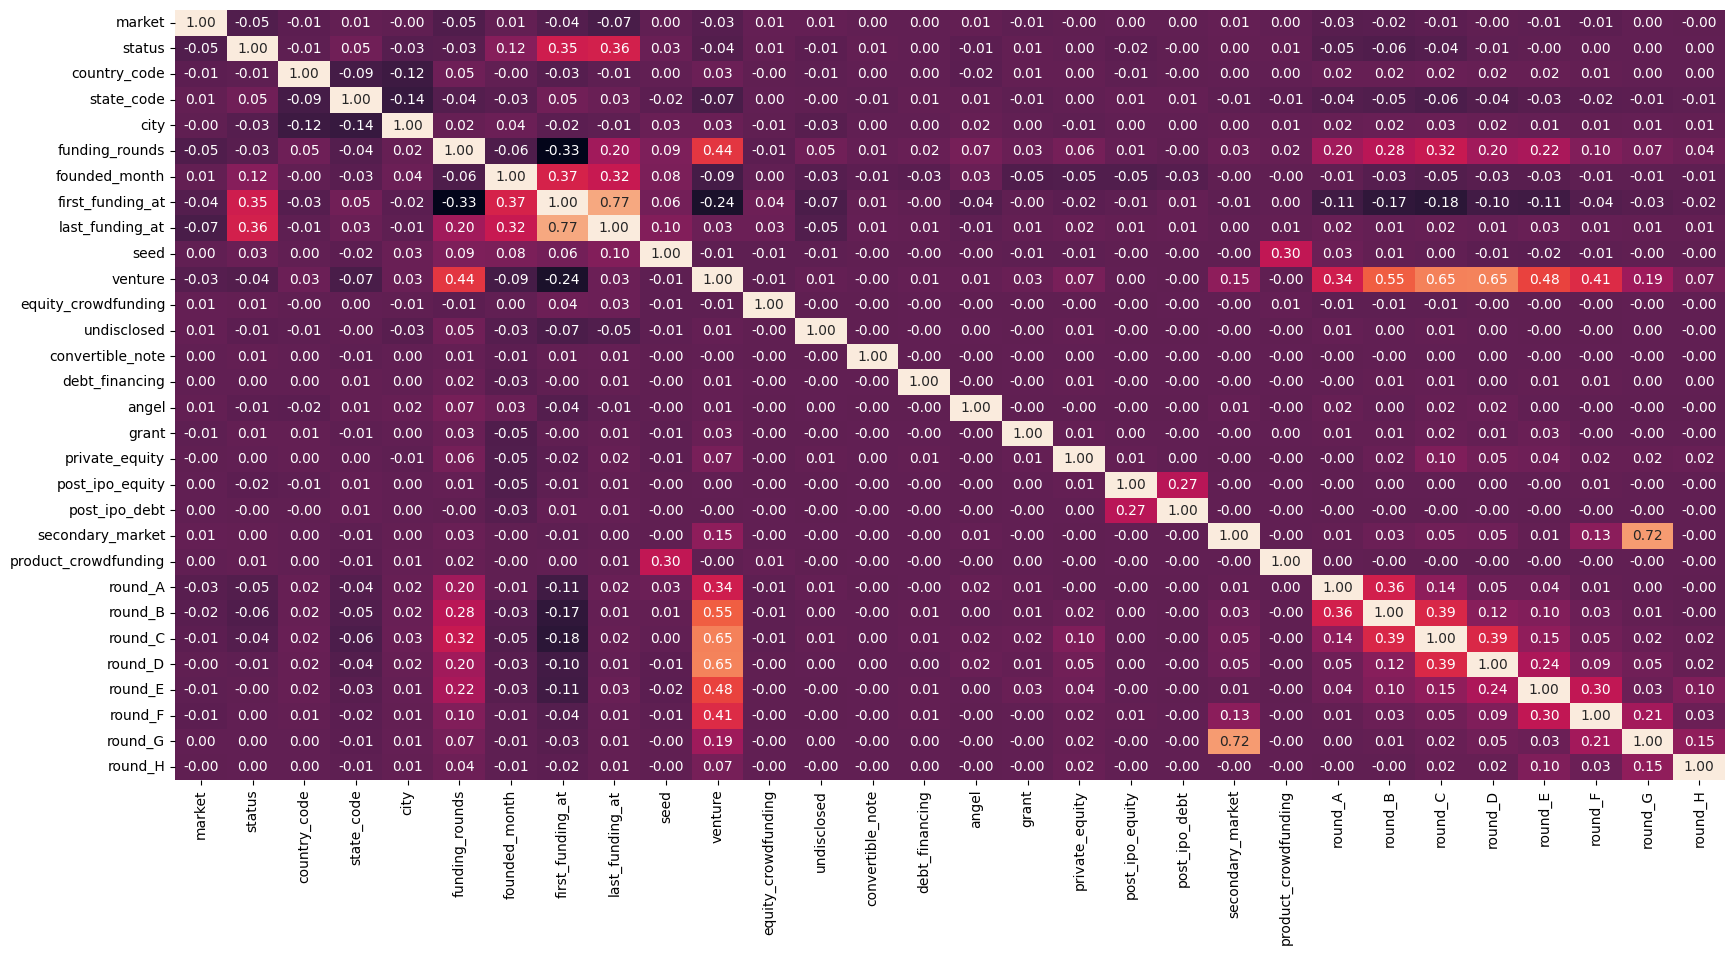

In [193]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df.corr(method='pearson'), ax=ax, annot=True, fmt='.2f', cbar=False)

## Разделение на выборки

In [194]:
dfX = df.drop('status', axis=1)
dfY = df['status']

X_train, X_test, Y_train, Y_test = train_test_split(dfX, dfY, test_size = 0.2, stratify = dfY, random_state = 10)

In [195]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(18572, 29)
(4644, 29)
(18572,)
(4644,)


## Обучение моделей

### Дерево решений

In [196]:
clf = GridSearchCV(DecisionTreeClassifier(random_state=10, class_weight='balanced'), {'max_depth':range(3,40)})

clf.fit(X_train, Y_train)

dt_clf = clf.best_estimator_

print(clf.best_score_, clf.best_params_)

0.7813913380022918 {'max_depth': 35}


### Случайный лес

In [197]:
rf_clf = RandomForestClassifier(random_state=10,  class_weight='balanced', n_jobs=-1)

rf_clf.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=10)

## Оценка качества моделей

### Метрики

**Accuracy (Точность)** = (число правильно предсказанных классов) / (общее число объектов)

**Precision** для каждого класса — это отношение числа правильно классифицированных объектов данного класса к числу всех объектов, которые были предсказаны как принадлежащие этому классу.

**Recall** для каждого класса — это отношение числа правильно классифицированных объектов данного класса к числу всех объектов, которые реально принадлежат этому классу.

**F1-score** для каждого класса — это гармоническое среднее между precision и recall для данного класса.

### Дерево решений

In [198]:
y_pred_dt = dt_clf.predict(X_test)

dt_accuracy = accuracy_score(Y_test, y_pred_dt)
dt_precision = precision_score(Y_test, y_pred_dt, average='weighted')
dt_recall = recall_score(Y_test, y_pred_dt, average='weighted')
dt_f1 = f1_score(Y_test, y_pred_dt, average='weighted')

### Случаный лес

In [199]:
y_pred_rf = rf_clf.predict(X_test)

rf_accuracy = accuracy_score(Y_test, y_pred_rf)
rf_precision = precision_score(Y_test, y_pred_rf, average='weighted')
rf_recall = recall_score(Y_test, y_pred_rf, average='weighted')
rf_f1 = f1_score(Y_test, y_pred_rf, average='weighted')

### Результаты

In [200]:
data = [
    ['accuracy', round(dt_accuracy, 3), round(rf_accuracy, 3)],
    ['precision',round(dt_precision, 3), round(rf_precision, 3)],
    ['recall', round(dt_recall, 3), round(rf_recall, 3)],
    ['f1', round(dt_f1, 3), round(rf_f1, 3)]
]

headers = ['Метрика \ модель', 'Дерево решений', 'Случайный лес']

print(tabulate(data, headers=headers, tablefmt="grid"))

+--------------------+------------------+-----------------+
| Метрика \ модель   |   Дерево решений |   Случайный лес |
+====================+==================+=================+
| accuracy           |            0.776 |           0.847 |
+--------------------+------------------+-----------------+
| precision          |            0.779 |           0.791 |
+--------------------+------------------+-----------------+
| recall             |            0.776 |           0.847 |
+--------------------+------------------+-----------------+
| f1                 |            0.777 |           0.803 |
+--------------------+------------------+-----------------+


Text(0.5, 1.0, 'Случайный лес')

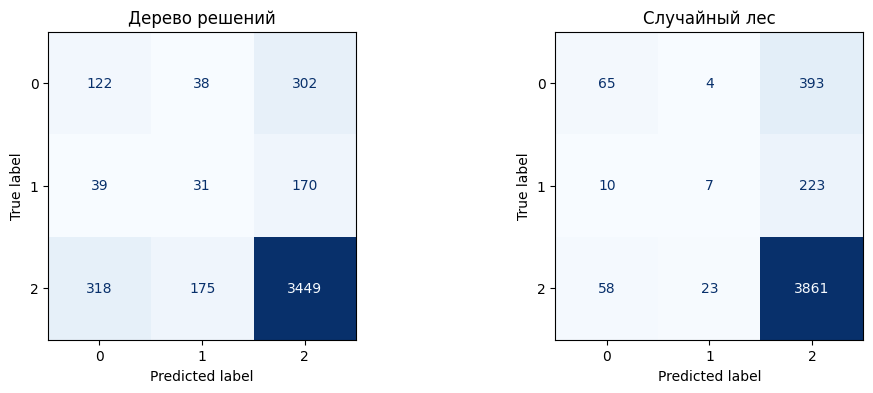

In [201]:
cm_dt = confusion_matrix(Y_test, y_pred_dt)
cm_rf = confusion_matrix(Y_test, y_pred_rf)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_dt)
disp1.plot(ax=axes[0], cmap=plt.cm.Blues, colorbar=False)
axes[0].set_title('Дерево решений')

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp2.plot(ax=axes[1], cmap=plt.cm.Blues, colorbar=False)
axes[1].set_title('Случайный лес')

```
0 - acquired
1 - closed
2 - operating
```

## Выводы

Точность модели "Дерево решений": **~77%**

Точность модели "Случайный лес": **~82%**

Качество моделей получилось относительно низким. Вероятно, это произошло вследствие того, что датасет содержал большое количество числовых признаков, в то время как используемые модели (определённые заданием РК) лучше подходят для датасетов с большим числом категориальных признаков.